# Explanations, Responsibility, and Blame

In this tutorial, we will demonstrate how to utilize the power of interventions to quantify explanations, responsibility, and blame in various situations. Whereas explanations, responsibility, and blame are normally theoretical concepts, in this tutorial, we will show how to convert these theoretical notions into quantifiable terms via the usage of the probabilistic programming tool: pyro. We will demonstrate how to calculate these terms using samples generated by various DAGs, and will explore how to make these methods modular to any type of DAG. 

# Installing Packages

In [1]:
!pip install torch torchvision torchaudio
!pip3 install pyro-ppl
!pip install pgmpy

     |████████████████████████████████| 1.9 MB 4.0 MB/s 
     |████████████████████████████████| 678 kB 5.0 MB/s 
     |████████████████████████████████| 1.9 MB 5.3 MB/s 


# Importing packages

In [2]:
import matplotlib.pyplot as plt
import pyro
import torch
import pyro.optim as optim
import numpy as np
from pyro.distributions import Categorical, OneHotCategorical
from pyro.distributions import Delta
from pyro.infer import SVI, Trace_ELBO
from pyro import param
from torch.distributions import constraints
from torch.distributions.transforms import *
from torch.distributions import TransformedDistribution as TransformedDist
import warnings; warnings.simplefilter('ignore')

#  5 Examples

Here we introduce our 5 examples, each for which we will compute explanation, blame, and responsibility. You will see that each of these 5 examples will identify key components these notions in some way, and that the methods we will use to quantify these explanations, blame, and responsbility will be consistent with our intuitions of how these ideas would be applied in the real world. 

# Television Model

Here, we define our first model: The TV model. The TV model has 2 exogenous variables and 2 endogenous variables. The first exogenous variable, U_0, directly models T, which symbolizes the functionality of the picture tube. In this instance, the hypothesis is that the picture tube being faulty (T = 0) is the cause of the picture not working (P = 0). Unfortunately, the picture can fail even if the picture is functional (T = 1) if other exogenous factors are faulty (U_1 = 1), and this happens 10% of the time. We show a DAG describing these relationships below

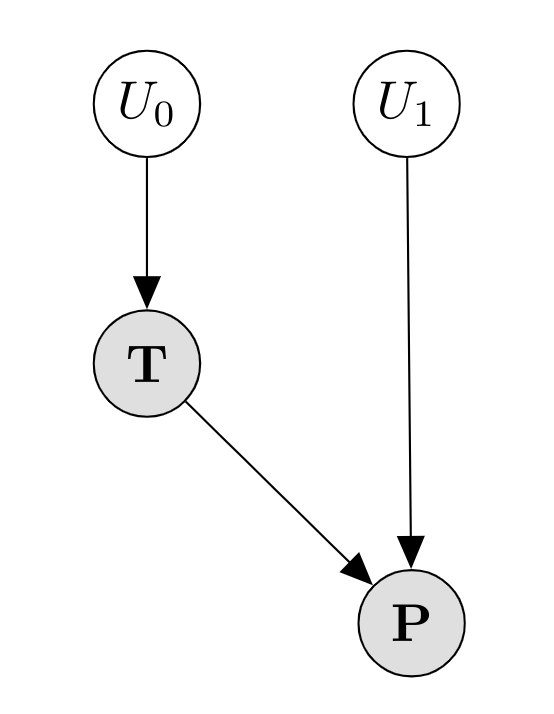

In [3]:
def exoVars_TV(p_U0=.5, p_U1=.9):
    ''' 
    Defines the exogenous variables for the TV model

        Parameters:

            p_U0 (float): probability of U_0 being 0
            p_U1 (float): probability of U_1 being 0
        
        Returns:

            exogenous (dict): Dictionary that contains categorial distribution
                              modelling each exogenous variable
    '''

    exogenous = {
        'U_0': Categorical(probs=torch.tensor([p_U0, 1 - p_U0])),
        'U_1': Categorical(probs=torch.tensor([p_U1, 1 - p_U1])),
    }
    return exogenous

def f_T_TV(U_0):
    '''
    Function that maps U_0 to T

        Parameters: 

            U_0 (int): Binary variable describing the value of U_0
        
        Returns: 

            U_0 (int): The value that T will take
    '''
    return U_0

def f_U1_TV(U_1):
    '''
    Function that maps U_1 to P

        Parameters: 

            U_1 (int): Binary variable describing the value of P
        
        Returns: 

            P (int): The value that P will take (the boolean opposite of U_1)
    '''
    if U_1 == 0.:
      return torch.tensor(1.)
    else:
      return torch.tensor(0.)

def model_TV(exogenous=exoVars_TV()):
    '''
    Function that models all the interaction of the SCM and returns samples

        Parameters:

            exogenous (dict): Dictionary of all the distributions of the 
                              exogenous variables

        Returns: 

            sample (dict): Returns a sample from the SCM
    '''
    
    U_0 = torch.tensor(pyro.sample("U_0", exogenous['U_0']).float())
    U_1 = torch.tensor(pyro.sample("U_1", exogenous['U_1']).float())
    T = pyro.sample('T', pyro.distributions.Delta(torch.tensor(f_T_TV(U_0))))
    P = pyro.sample('P', pyro.distributions.Delta(f_U1_TV(U_1) and T))
    return {'U_0': U_0, 'U_1': U_1, 'T': T, 'P': P}

# sample a sample_size number of samples from the TV SCM. 
samples_TV = []
sample_size = 1000
trace_handler = pyro.poutine.trace(model_TV)
for i in range(sample_size):
    trace = trace_handler.get_trace()
    U_0 = trace.nodes['U_0']['value']
    U_1 = trace.nodes['U_1']['value']
    T = trace.nodes['T']['value']
    P = trace.nodes['P']['value']
    prob = np.exp(trace.log_prob_sum())
    samples_TV.append({'U_0': U_0, 'U_1': U_1, 
                       'T': T, 'P': P, 'prob':prob, 'idx': i})

# Forest Fire Model

The forest fire model is perhaps the most complicated of this suite. We have 3 exogenous variables that control 3 endogenous variables: April Showers (AS), Electrical Storms (ESM) in May, and Electrical Storms in June (ESJ), and they are all causes of our effect variable in question: Forest Fires (FF). If there is an April Shower (AS=1), there cannot be a Forest Fire in May (FF != 1), however, if there isn't an April Shower (AS=0), and there are Electrical Storms in May (ESM=1), then there will be a forest fire in May (FF=1). If there is an April Shower (AS = 1) or there aren't any Electrical Storms in May (ESM = 0), then if there is an Electrical Storm in June (ESJ = 1), then there will be a Forest Fire in June (FF = 2). If there are never any electrical storms (ESM = 0 and ESJ = 0), then regardless of the value of April Showers (AS), there will be no Forest Fires (FF = 0). We show a DAG describing these relationships below 

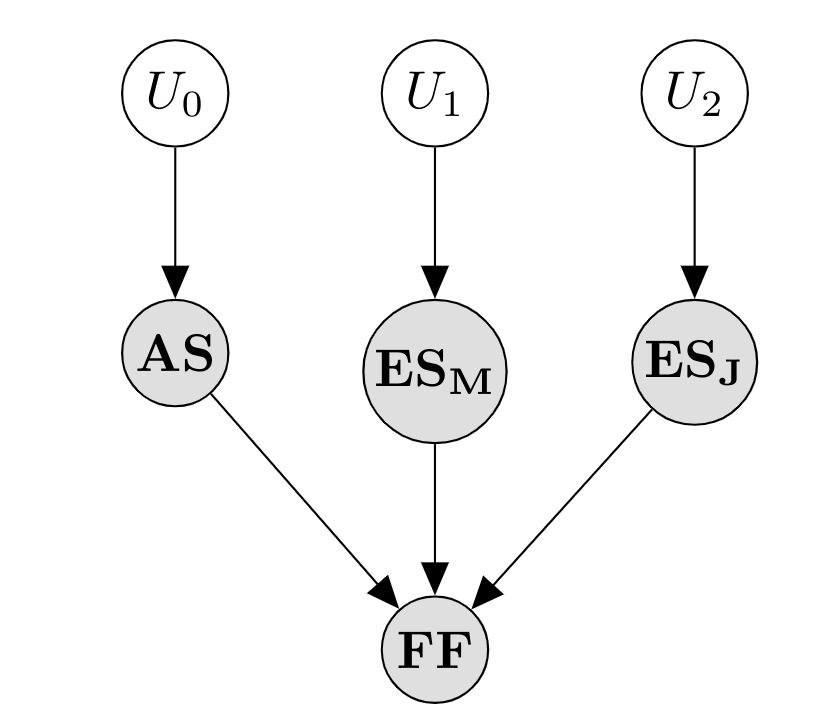

In [4]:
# Forest Fires

def exoVars_fire(p_U0=.5, p_U1=.5, p_U2=0.5):
    ''' 
    Defines the exogenous variables for the forest fire model

        Parameters:

            p_U0 (float): probability of U_0 being 0
            p_U1 (float): probability of U_1 being 0
            p_U2 (float): probability of U_2 being 0
        
        Returns:

            exogenous (dict): Dictionary that contains categorial distribution
                              modelling each exogenous variable
    '''
    exogenous = {
        'U_0': Categorical(probs=torch.tensor([p_U0, 1 - p_U0])),
        'U_1': Categorical(probs=torch.tensor([p_U1, 1 - p_U1])), 
        'U_2': Categorical(probs=torch.tensor([p_U2, 1 - p_U2]))
    }
    return exogenous

# April Showers
def f_AS_fire(U_0):
    '''
    Function that maps U_0 to AS

        Parameters: 

            U_0 (int): Binary variable describing the value of U_0
        
        Returns: 

            AS (int): The value that AS will take
    '''

    return pyro.sample('AS', pyro.distributions.Delta(torch.tensor(U_0)))

# Electric storm
def f_ES_fire(U_1, U_2):
    '''
    Function that maps U_1, U_2 to ESJ and ESM

        Parameters: 

            U_1 (int): Binary variable describing the value of U_1
            U_2 (int): Binary variable describing the value of U_2
        
        Returns: 

            ESM (int): The value that ESM will take
            ESJ (int): The value that ESJ will take
    '''
    return pyro.sample('ESM', pyro.distributions.Delta(U_1)), \
    pyro.sample('ESJ', pyro.distributions.Delta(U_2))

# Forest fire condition
def f_FF_fire(AS, ESM, ESJ):
    '''
    Function that maps U_1, U_2 to ESJ and ESM

        Parameters: 

            U_1 (int): Binary variable describing the value of U_1
            U_2 (int): Binary variable describing the value of U_2
        
        Returns: 

            ESM (int): The value that ESM will take
            ESJ (int): The value that ESJ will take
    '''
    if (AS == 0. and ESM == 1.):
        temp =  torch.tensor(1.)
    elif ESJ == 1. and (AS == 1. or ESM == 0):
        temp = torch.tensor(2.)
    else:
        temp = torch.tensor(0.)
    return pyro.sample('FF', pyro.distributions.Delta(temp))

# Data generation Model definition
def model_fire(exogenous=exoVars_fire()):
    '''
    Function that models all the interaction of the SCM and returns samples

        Parameters:

            exogenous (dict): Dictionary of all the distributions of the 
                              exogenous variables

        Returns: 

            sample (dict): Returns a sample from the SCM
    '''
    U_0 = torch.tensor(pyro.sample("U_0", exogenous['U_0']).float())
    U_1 = torch.tensor(pyro.sample("U_1", exogenous['U_1']).float())
    U_2 = torch.tensor(pyro.sample("U_2", exogenous['U_2']).float())

    AS = f_AS_fire(U_0)
    ESM, ESJ = f_ES_fire(U_1, U_2)
    FF = f_FF_fire(AS, ESM, ESJ)

    return {'U_0': U_0, 'U_1': U_1, 'U_2': U_2, 'AS': AS, 
            'ESM': ESM, 'ESJ': ESJ, 'FF': FF}

# Collect samples of size sample_size from model_fire
samples_fire = []
sample_size = 1000
trace_handler = pyro.poutine.trace(model_fire)
for i in range(sample_size):
    trace = trace_handler.get_trace()
    U_0 = trace.nodes['U_0']['value']
    U_1 = trace.nodes['U_1']['value']
    U_2 = trace.nodes['U_2']['value']
    AS = trace.nodes['AS']['value']
    ESM = trace.nodes['ESM']['value']
    ESJ = trace.nodes['ESJ']['value']
    FF = trace.nodes['FF']['value']

    prob = np.exp(trace.log_prob_sum())
    samples_fire.append({'U_0': U_0, 'U_1': U_1, 'U_2': U_2, 'AS': AS, 
                         'ESM': ESM, 'ESJ': ESJ, 'FF' : FF, 
                         'prob':prob, 'idx': i})

# Victoria Goes to the Beach

In this example, Victoria goes to the beach (B=1) to seek a tan (T=1). However, her going to the beach is typically not a sufficient explanation for her getting said tan, since the beach also has to be sunny in order for her to get a tan (Sun=1). Additionally, it may not be the only explanation of her getting a tan since Victoria could also go to the tanning salon (Salon=1) to get a tan. The relationships are as follows, if Victoria goes to the beach (B=1) and it is sunny (Sun=1), then she will get a tan (T=1). If Victoria goes to the tanning salon (Salon=1), then she will also get a tan. If neither of these circumstances happen ((B and Sun) = 0 and (Salon = 0)), then she will not get a tan (T=0). We show a DAG describing these relationships below:  

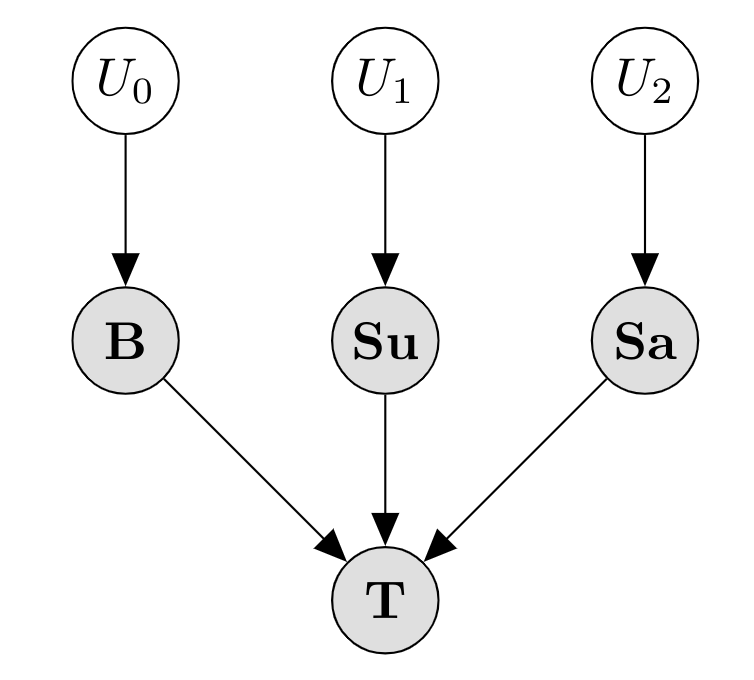

In [5]:
# Draw samples for beach

def exoVars_beach(p_U0=.1, p_U1=.1, p_U2=.5):
    ''' 
    Defines the exogenous variables for the forest fire model

        Parameters:

            p_U0 (float): probability of U_0 being 0
            p_U1 (float): probability of U_1 being 0
            p_U2 (float): probability of U_2 being 0
        
        Returns:

            exogenous (dict): Dictionary that contains categorial distribution
                                modelling each exogenous variable
    '''  
    exogenous = {
        'U_0': Categorical(probs=torch.tensor([p_U0, 1 - p_U0])),
        'U_1': Categorical(probs=torch.tensor([p_U1, 1 - p_U1])),
        'U_2': Categorical(probs=torch.tensor([p_U2, 1 - p_U2]))
    }
    return exogenous

def f_B_beach(U_0):
    '''
    Function that maps U_0 to Victoria going to the Beach (B)

        Parameters: 

            U_0 (int): Binary variable describing the value of U_0
        
        Returns: 

            B (int): The value that B will take
    '''
    
    return U_0

def f_Sun_beach(U_1):
    '''
    Function that maps U_1 to the beach being sunny (Sun=1)

        Parameters: 

            U_1 (int): Binary variable describing the value of U_1
        
        Returns: 

            Sun (int): The value that Sun will take
    '''
    return U_1

def f_Salon_beach(U_2):
    '''
    Function that maps U_2 to Victoria going to the salon (Salon=1)

        Parameters: 

            U_2 (int): Binary variable describing the value of U_2
        
        Returns: 

            Salon (int): The value that Salon will take
    '''
    return U_2

def model_beach(exogenous=exoVars_beach()):
    '''
    Function that models all the interaction of the SCM and returns samples

        Parameters:

            exogenous (dict): Dictionary of all the distributions of the 
                              exogenous variables

        Returns: 

            sample (dict): Returns a sample from the SCM
    '''
    U_0 = torch.tensor(pyro.sample("U_0", exogenous['U_0']).float())
    U_1 = torch.tensor(pyro.sample("U_1", exogenous['U_1']).float())
    U_2 = torch.tensor(pyro.sample("U_2", exogenous['U_2']).float())
    B = pyro.sample('B', pyro.distributions.Delta(torch.tensor(f_B_beach(U_0))))
    Sun = pyro.sample('Sun', 
                    pyro.distributions.Delta(torch.tensor(f_Sun_beach(U_1))))
    Salon = pyro.sample('Salon', 
                        pyro.distributions.Delta(torch.tensor(f_Salon_beach(U_2))))
    T = pyro.sample('T', pyro.distributions.Delta(Salon or (Sun and B)))
    return {'U_0': U_0, 'U_1': U_1, 'U_2': U_2, 
            'B': B, 'Sun': Sun, 'Salon': Salon, 'T': T}

# Collect samples of size sample_size from model_beach
samples_beach = []
sample_size = 1000
trace_handler = pyro.poutine.trace(model_beach)
for i in range(sample_size):
    trace = trace_handler.get_trace()
    U_0 = trace.nodes['U_0']['value']
    U_1 = trace.nodes['U_1']['value']
    U_2 = trace.nodes['U_2']['value']
    T = trace.nodes['T']['value']
    B = trace.nodes['B']['value']
    Sun = trace.nodes['Sun']['value']
    Salon = trace.nodes['B']['value']
    prob = np.exp(trace.log_prob_sum())
    samples_beach.append({'U_0': U_0, 'U_1': U_1, 'U_2': U_2, 'B': B, 'Sun': Sun,
                          'Salon': Salon, 'T': T, 'prob':prob, 'idx': i})

# Paresis

In this example, we analyze the conditions by which a patient can contract Paresis (P). If a patient contracts Syphillis (S=1) and has outside genetic conditions (read: exogenous) (U_1 = 1), then the patient will contract Paresis (P=1). In every other scenario, the patient will not contract Paresis (P=0). We show a DAG describing these relationships below.

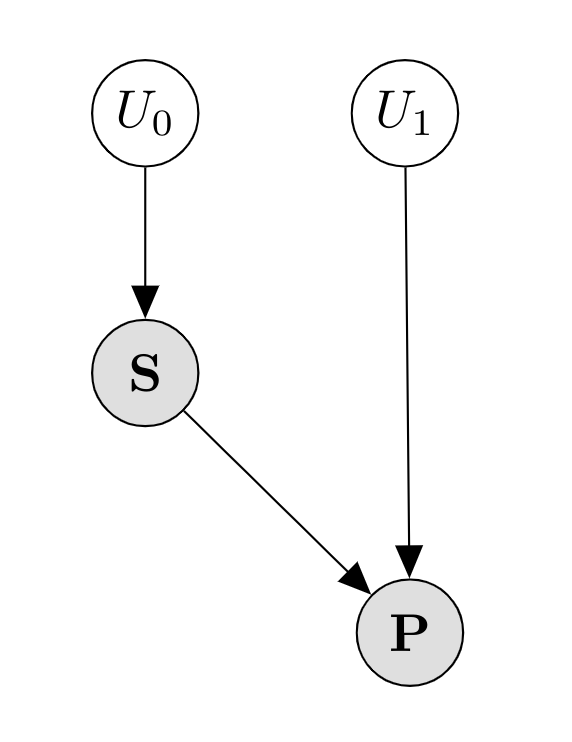

In [8]:
def exo_vars_paresis(p_U0=0.004 , p_U1=0.4):
    ''' 
    Defines the exogenous variables for the Paresis model

        Parameters:

            p_U0 (float): probability of U_0 being 0
            p_U1 (float): probability of U_1 being 0
        
        Returns:

            exogenous (dict): Dictionary that contains categorial distribution
                                modelling each exogenous variable
    '''  
    exogenous = {
        'U_0' : Categorical( probs = torch.tensor([p_U0, 1 - p_U0])),
        'U_1' : Categorical( probs = torch.tensor([p_U1, 1 - p_U1]))
    }
    return exogenous

def f_S_paresis(U_0):
    '''
    Function that maps U_0 to patient contract Syphillis (S)

        Parameters: 

            U_1 (int): Binary variable describing the value of U_1
        
        Returns: 

            S (int): The value that S will take
    '''
    return U_0

def f_U1_paresis(U_1):
    '''
    Function that maps U_1 that contributes to patient contracting
    Paresis (P=1)

        Parameters: 

            U_1 (int): Binary variable describing the value of U_1
        
        Returns: 

            U_1 (int): The value that will be used to compute whether patient
                       contract Paresis or not
    '''

    if U_1 == 1:
        return torch.tensor(1.)
    else:
        return torch.tensor(0.)

def model_paresis(exogenous=exo_vars_paresis()):
    '''
    Function that models all the interaction of the SCM and returns samples

        Parameters:

            exogenous (dict): Dictionary of all the distributions of the 
                              exogenous variables

        Returns: 

            sample (dict): Returns a sample from the SCM
    '''
    U_0 = torch.tensor(pyro.sample("U_0", exogenous['U_0']).float())
    U_1 = torch.tensor(pyro.sample("U_1", exogenous['U_1']).float())
    S = pyro.sample('S', pyro.distributions.Delta(torch.tensor(U_0)))
    P = pyro.sample('P', pyro.distributions.Delta(S and f_U1_paresis(U_1)))
    return {'U_0': U_0, 'U_1': U_1, 'S': S, 'P': P} 

# Sample from Paresis SCM 
samples_paresis = []
sample_size = 10000
trace_handler = pyro.poutine.trace(model_paresis)
for i in range(sample_size):
    trace = trace_handler.get_trace()
    U_0 = trace.nodes['U_0'] ['value']
    U_1 = trace.nodes['U_1']['value']
    S = trace.nodes['S']['value']
    P = trace.nodes['P']['value']
    prob = np.exp(trace.log_prob_sum())
    samples_paresis.append({'U_0': U_0, 'U_1': U_1, 'S': S, 
                            'P': P, 'prob' : prob, 'idx': i})

# Arsonist Example

Taking a more sinister turn, we begin exploring the possibility of two arsonists dropping matches in a forest in the hopes of burning it down. In the disjunctive scenario, if either arsonists drops a match (ML1 = 1 or ML2 = 1), then the forest will burn down (FB=1). If neither arsonist drops a match (ML1 = 0 and ML2 = 0), then the forest will not burn down (FB=0). In the conjunctive case, both arsonists need to drop a match (ML1=1 and ML2=1) in order for the forest to burn down (FB=1). If this doesn't happen (ML1=0 or ML2=0), then the forest doesn't burn down (FB=0). We display a DAG below that demonstrates these interactions

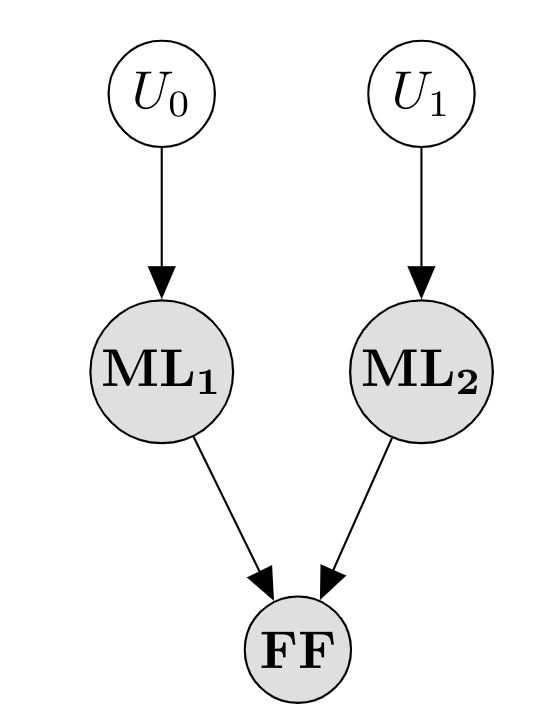

In [10]:
def exoVars_match():
    ''' 
    Defines the exogenous variables for the Paresis model

        Parameters:

            p_U0 (float): probability of U_0 being 0
            p_U1 (float): probability of U_1 being 0
        
        Returns:

            exogenous (dict): Dictionary that contains categorial distribution
                                modelling each exogenous variable
    '''  
    exogenous = {
        'U_0': pyro.distributions.Bernoulli(0.5),     
        'U_1': pyro.distributions.Bernoulli(0.5)
    }
    return exogenous

def f_ML1_match(U0):
    '''
    Function that maps U_0 that contributes to Arsonist 1 dropping a match (ML1)

        Parameters: 

            U_0 (int): Binary variable describing the value of U_1
        
        Returns: 

            ML1 (int): Value of ML1
    '''

    return pyro.sample('ML1', pyro.distributions.Delta(torch.tensor(U0)))

def f_ML2_match(U1):
    '''
    Function that maps U_1 that contributes to Arsonist 2 dropping a match (ML2)

        Parameters: 

            U_1 (int): Binary variable describing the value of U_1
        
        Returns: 

            ML2 (int): Value of ML2
    '''
    return pyro.sample('ML2', pyro.distributions.Delta(torch.tensor(U1)))

def f_FB_CONJUNCTIVE_match(ML1,ML2):
    '''
    Function that maps ML1 and ML2 to Forest Burning (FB) in conjunctive case

        Parameters: 

            ML1 (int): Binary variable describing the value of ML1
            ML2 (int): Binary variable describing the value of ML1
        
        Returns: 

            FB_CONJUNCTIVE (int): Forest burning in conjunctive case
    '''
    temp=ML1 and ML2
    return pyro.sample('FB_CONJUNCTIVE', pyro.distributions.Delta(temp))

def f_FB_DISJUNCTIVE_match(ML1,ML2):
    '''
    Function that maps ML1 and ML2 to Forest Burning (FB) in disjunctive case

        Parameters: 

            ML1 (int): Binary variable describing the value of ML1
            ML2 (int): Binary variable describing the value of ML1
        
        Returns: 

            FB_DISJUNCTIVE (int): Forest burning in disjunctive case
    '''
    temp=ML1 or ML2
    return pyro.sample('FB_DISJUNCTIVE', pyro.distributions.Delta(temp))

def model_match(exogenous=exoVars_match()):
    '''
    Function that models all the interaction of the SCM and returns samples

        Parameters:

            exogenous (dict): Dictionary of all the distributions of the 
                              exogenous variables

        Returns: 

            sample (dict): Returns a sample from the SCM
    '''
    U1 = pyro.sample("U_0", exogenous['U_0'])
    U2 = pyro.sample("U_1", exogenous['U_1'])
    ML1 = f_ML1_match(U1)
    ML2 = f_ML2_match(U2)
    FB_CONJUNCTIVE = f_FB_CONJUNCTIVE_match(ML1,ML2)
    FB_DISJUNCTIVE = f_FB_DISJUNCTIVE_match(ML1,ML2)
    return {'U_0': U_0, 'U_1': U_1, 'ML1': ML1, 'ML2': ML2,
            'FB_DISJUNCTIVE': FB_DISJUNCTIVE,'FB_CONJUNCTIVE':FB_CONJUNCTIVE}

# Sample samples of size sample_size from model_match
samples_match = []
sample_size = 10000
trace_handler = pyro.poutine.trace(model_match)
for i in range(sample_size):
    trace = trace_handler.get_trace()
    U_0 = trace.nodes['U_0']['value']
    U_1 = trace.nodes['U_1']['value']
    ML1 = trace.nodes['ML1']['value']
    ML2 = trace.nodes['ML2']['value']
    FB_CONJUNCTIVE = trace.nodes['FB_CONJUNCTIVE']['value']
    FB_DISJUNCTIVE = trace.nodes['FB_DISJUNCTIVE']['value']
    prob = np.exp(trace.log_prob_sum())
    samples_match.append({'U_0': U_0, 'U_1': U_1, 'ML1': ML1, 'ML2': ML2,
                          'FB_DISJUNCTIVE' : FB_DISJUNCTIVE,
                          'FB_CONJUNCTIVE':FB_CONJUNCTIVE, 
                          'prob':prob, 'idx': i})

# Partial Explanations

In this section, we begin by introducing the notion of partial explanations. Often times, complete explanations are not possible, or single causes do not constitute complete explanations. Take, for instance, Victoria going to the beach to get tanned. Although Victoria going to the beach alone does not constitute a complete explanation of her getting tanned, it does serve as a strong partial explanation if we know that the probability of the beach being sunny is very high. Another example of partial explanations playing a strong role is the TV example, where the picture tube being faulty is usually a very strong explanation of the picture not showing, however, there are cases that there are other explanations such as other components of the television failing. 

To understand partial explanations then, we have to define them with respect to our epistemic state, quantitatively, this means defining them with respect to the probability distribution of our exogenous variables. Since the beach being sunny is very likely, Victoria going to the beach becomes a very good explanation of her being tanned. Conversely, if this were winter and the beach were never sunny, then we would perhaps try to seek alternative explanations of Victoria being tanned. 

Quantitatively, the strength of a partial explanation is defined by two values: $(\alpha, \beta)$.
And their computations are as follows:

$$ \alpha = Pr(\mathcal{K}(X=x, \phi, SC2 | \mathcal{K}_{X=x \cap \phi})$$.
$$ \beta = Pr(\mathcal{K}(X=x, \phi, SC3)$$.

We define SC2 and SC3 as: 

SC2: Some conjunct of $X=x$ is part of the cause of $\phi$ in $(\mathcal{M}, u)$. Precisely, there exists conjunct $X=x$ and another (possibly empty) conjunct $Y=y$ s.t. $X = x$ and $y$ is a cause of $\phi$ in $(\mathcal{M}, u)$. More specifically, AC1, AC2, and AC3 all hold for $X \cap Y$, where AC1 specifies that $X=x$ and $\phi$ occur simultaneously, AC2 specifies necessity and sufficiency, and AC3 specifies minimality. 

SC3: $(M, u) \models [X = x]_\phi$. This is a key condition that states that intervening $X = x$ results in $\phi$ in all contexts. This is effectively a sufficiency condition

We begin by computing $\alpha$. We notice that the first thing we need to compute $\alpha$ is to first condition on $\mathcal{K}_{X=x \cap \phi}$. This expression means we need to find the set of samples where both the cause and the effect take on active values. From there, since AC1 is trivially satisfied and AC3 is assumed, what remains is to compute the probability of necessity and sufficiency of the samples we have collected. We recall that the computation for probability of necessity and sufficiency is as follows:

$$P(X=1, Y=1)PN + P(X=0, Y=0)PS$$

where

$$PN = P(Y_{X=0} = 0 | X=1, Y=1)$$ 
and
$$PS = P(Y_{X=1} = 1 | X=0, Y=0)$$

represent the probabilities of necessity and probabilities of sufficiency respectively. 

In [11]:
def compute_PNS_scores(model, samples_X1Y1, causes, effect, exo_vars):
    '''  
    Computes PNS scores for an exogenous model and a set of samples
  
        Parameters:

            model (function): model we sampled from
            samples_X1Y1 (list of samples): samples that have consistent 
                                            active cause and effect values
            causes (list of tuples): a list of tuples where element 0 contains
                                     the name of the endogenous variable and 
                                     element 1 contains its active value
            effect (tuple): element 0 contains the name of the effect variable
                            and element 1 
            exo_vars (list of strings): a list of strings indicating the 
                                        names of exogenous variables 
    '''

    cause_dict = {}
    for cause in causes:
        cause_dict[cause[0]] = cause[1]

    anti_cause_dict = {}
    for cause, value in cause_dict.items():
        anti_cause_dict[cause] = torch.tensor(int(not bool(value)))

    intervened_model_X1 = pyro.do(model, data=cause_dict)
    intervened_model_X0 = pyro.do(model, data=anti_cause_dict)
    Pr_X1Y1 = 0
    Pr_X0Y0 = 0
    P_Necessity = 0
    P_Sufficiency = 0

    for sample in samples_X1Y1:
        allCause = True
        for cause in causes:
            if sample[cause[0]] == cause[1]:
                pass
            else:
                allCause = False

        exo_dict = {}
        for exo_var in exo_vars:
            exo_dict[exo_var] = sample[exo_var]

        if allCause and sample[effect[0]] == effect[1]: 
      
            conditioned_intervened_model = pyro.condition(intervened_model_X0, 
                                                          data=exo_dict) 
            Pr_X1Y1 += 1  
            effect_val = conditioned_intervened_model()[effect[0]]
            if effect_val != effect[1]: 
                P_Necessity += 1

        elif not allCause and sample[effect[0]] != effect[1]: 
            conditioned_intervened_model = pyro.condition(intervened_model_X1, 
                                                          data=exo_dict) 
            Pr_X0Y0 += 1
            effect_val = conditioned_intervened_model()[effect[0]]
            if effect_val == effect[1]: # Does Y = 1
                P_Sufficiency += 1
        else:
            continue

    if Pr_X1Y1 == 0 and Pr_X0Y0 == 0:
        PNS = 0

    elif Pr_X0Y0 == 0 and Pr_X1Y1 != 0:
        P_Necessity /= Pr_X1Y1
        Pr_X1Y1 /= len(samples_X1Y1)
        PNS = Pr_X1Y1 * P_Necessity

    elif Pr_X1Y1 == 0 and Pr_X0Y0 != 0:
        P_Sufficiency /= Pr_X0Y0
        Pr_X0Y0 /= len(samples_X1Y1)
        PNS = Pr_X0Y0 * P_Sufficiency

    else:
        P_Necessity /= Pr_X1Y1
        P_Sufficiency /= Pr_X0Y0
        Pr_X1Y1 /= len(samples_X1Y1)
        Pr_X0Y0 /= len(samples_X1Y1)
        PNS = Pr_X1Y1 * P_Necessity + Pr_X0Y0 * P_Sufficiency
  
    return PNS

def compute_alpha(causes, effect, model, exo_vars, samples):
    '''  
    Computes PNS scores for an exogenous model and a set of samples
  
        Parameters:

            model (function): model we sampled from
            samples_X1Y1 (list of samples): samples that have consistent 
                                            active cause and effect values
            causes (list of tuples): a list of tuples where element 0 contains
                                     the name of the endogenous variable and 
                                     element 1 contains its active value
            effect (tuple): element 0 contains the name of the effect variable
                            and element 1 
            exo_vars (list of strings): a list of strings indicating the 
                                        names of exogenous variables 
    '''
    samples_X1Y1 = []
    for sample in samples:
        allCause = True
        for cause in causes:
            if sample[cause[0]] == cause[1]:
                pass
            else:
                allCause = False
        if allCause and sample[effect[0]] == effect[1]:
            samples_X1Y1.append(sample)

  
  
    return compute_PNS_scores(model=model, samples_X1Y1=samples_X1Y1, 
                              causes=causes, effect=effect, exo_vars=exo_vars)

print('alpha for TV:', 
      compute_alpha(causes=[('T', torch.tensor(0))], effect=('P', torch.tensor(0)), 
                    model=model_TV, exo_vars=['U_0', 'U_1'], samples=samples_TV))
print('alpha for beach:', 
      compute_alpha(causes=[('B', torch.tensor(1))], effect=('T', torch.tensor(1)), 
                    model=model_beach, exo_vars=['U_0', 'U_1', 'U_2'], 
                    samples=samples_beach))
print('alpha for electric storms in May:', 
      compute_alpha(causes=[('ESM', torch.tensor(1)), ('AS', torch.tensor(0))], 
                    effect=('FF', torch.tensor(1)), model=model_fire, 
                    exo_vars=['U_0', 'U_1', 'U_2'], samples=samples_fire))
print('alpha for electric storms in June:', 
      compute_alpha(causes=[('ESM', torch.tensor(0)), ('ESJ', torch.tensor(1))],
                    effect=('FF', torch.tensor(2)), model=model_fire, 
                    exo_vars=['U_0', 'U_1', 'U_2'], samples=samples_fire))
print('alpha for paresis:', 
      compute_alpha(causes=[('S', torch.tensor(1))], effect=('P', torch.tensor(1)),
                    model=model_paresis, exo_vars=['U_0', 'U_1'], 
                    samples=samples_paresis))
print('alpha for arsonist 1 disjunctive:', 
      compute_alpha(causes=[('ML1', torch.tensor(1))], 
                    effect=('FB_DISJUNCTIVE', torch.tensor(1)), 
                    model=model_match, exo_vars=['U_0', 'U_1'], samples=samples_match))
print('alpha for arsonist 2 disjunctive:', 
      compute_alpha(causes=[('ML2', torch.tensor(1))], 
                    effect=('FB_DISJUNCTIVE', torch.tensor(1)), 
                    model=model_match, exo_vars=['U_0', 'U_1'], samples=samples_match))
print('alpha for arsonists conjunctive:', 
      compute_alpha(causes=[('ML1', torch.tensor(1)), ('ML2', torch.tensor(1))], 
                    effect=('FB_CONJUNCTIVE', torch.tensor(1)), 
                    model=model_match, exo_vars=['U_0', 'U_1'], samples=samples_match))



alpha for TV: 0.9158316633266533
alpha for beach: 0.46539379474940334
alpha for electric storms in May: 1.0
alpha for electric storms in June: 1.0
alpha for paresis: 1.0
alpha for arsonist 1 disjunctive: 0.5085182250396196
alpha for arsonist 2 disjunctive: 0.4961413484971568
alpha for arsonists conjunctive: 1.0


# Explanations for $\alpha$ values

Let's breakdown the $\alpha$ values we see for each of the examples. 

1.   In the TV example, we get an $\alpha$ value of 0.9 because there is still a 10% chance that it was other exogenous causes that caused the picture to fail

2.   In the beach example, we get an $\alpha$ value of 0.5 because there is a 50% chance that Victoria also goes to the tanning salon which is why she's tanned

3.   In the electrical storms in May example, we get an $\alpha$ value of 1 because both April Showers and Electrical Storms in May are necessary and sufficient for there to be a forest fire in May

4.   Similarly, in the electrical storms in June example, we get an $\alpha$ vaalue of 1 because having no electrical storms in May and having electrical storms in June are necessary and sufficient for there to be a forest fire in June

5.   In the paresis case, we get an $\alpha$ value of 1 because having Syphillis is necessary and sufficient for a patient to get Paresis when we condition on all the contexts where Paresis is contracted

6.   In the 2 arsonists disjunctive case, we get an $\alpha$ value of 0.5 because 50% of the time, the other arsonist also drops a match making the match that the arsonist dropped not necessary for the forest to burn down. 

7.   In the arsonists conjunctive case, we get an $\alpha$ of 1 because having both arsonists drop a match is necessary and sufficient for the forest to burn down



# Computing $\beta$

Now we seek to compute the value of $\beta$. Recall $\beta$ is described by

$$ \beta = Pr(\mathcal{K}(X=x, \phi, SC3)$$.

and SC3 described by

SC3: $(M, u) \models [X = x]_\phi$. This is a key condition that states that intervening $X = x$ results in $\phi$ in all contexts. This is effectively a sufficiency condition

Intuitively, this means that we just have to find the proportion of samples where the cause is sufficient for the effect to happen



In [12]:
def compute_beta(causes, effect, model, exo_vars, samples):
    '''  
    Computes beta scores for an exogenous model and a set of samples
  
        Parameters:

            causes (list of tuples): a list of tuples where element 0 contains
                                     the name of the endogenous variable and 
                                     element 1 contains its active value
            effect (tuple): element 0 contains the name of the effect variable
                            and element 1 
            model (function): model we sampled from
            exo_vars (list of strings): a list of strings indicating the 
                                        names of exogenous variables 
            samples (list of samples): samples from a model
    '''

    cause_dict = {}
    for cause in causes:
        # This is the intervention
        cause_dict[cause[0]] = cause[1]

        intervened_model_X1 = pyro.do(model, data=cause_dict)

    P_Sufficiency = 0
    for sample in samples:
        exo_dict = {}
        for exo_var in exo_vars:
            exo_dict[exo_var] = sample[exo_var]
        conditioned_intervened_model = pyro.condition(intervened_model_X1, 
                                                        data=exo_dict)
        if conditioned_intervened_model()[effect[0]] == effect[1]:
            P_Sufficiency += 1
    return P_Sufficiency / len(samples)

print('beta for TV:', 
      compute_beta(causes=[('T', torch.tensor(0))], effect=('P', torch.tensor(0)), 
                   model=model_TV, exo_vars=['U_0', 'U_1'], samples=samples_TV))
print('beta for beach:', 
      compute_beta(causes=[('B', torch.tensor(1))], effect=('T', torch.tensor(1)), 
                   model=model_beach, exo_vars=['U_0', 'U_1', 'U_2'], samples=samples_beach))
print('beta for electric storms in May:', 
      compute_beta(causes=[('ESM', torch.tensor(1)), ('AS', torch.tensor(0))], 
                   effect=('FF', torch.tensor(1)), model=model_fire, 
                   exo_vars=['U_0', 'U_1', 'U_2'], samples=samples_fire))
print('beta for electric storms in June:', 
      compute_beta(causes=[('ESM', torch.tensor(0)), ('ESJ', torch.tensor(1))], 
                   effect=('FF', torch.tensor(2)), model=model_fire, 
                   exo_vars=['U_0', 'U_1', 'U_2'], samples=samples_fire))
print('beta for paresis:', 
      compute_beta(causes=[('S', torch.tensor(1))], effect=('P', torch.tensor(1)), 
                   model=model_paresis, exo_vars=['U_0', 'U_1'], samples=samples_paresis))
print('beta for arsonist 1 disjunctive:', 
      compute_beta(causes=[('ML1', torch.tensor(1))], 
                   effect=('FB_DISJUNCTIVE', torch.tensor(1)), 
                   model=model_match, exo_vars=['U_0', 'U_1'], samples=samples_match))
print('beta for arsonist 2 disjunctive:', 
      compute_beta(causes=[('ML2', torch.tensor(1))], 
                   effect=('FB_DISJUNCTIVE', torch.tensor(1)), 
                   model=model_match, exo_vars=['U_0', 'U_1'], samples=samples_match))
print('beta for arsonists conjunctive:', 
      compute_beta(causes=[('ML1', torch.tensor(1)), ('ML2', torch.tensor(1))], 
                   effect=('FB_CONJUNCTIVE', torch.tensor(1)), model=model_match, 
                   exo_vars=['U_0', 'U_1'], samples=samples_match))




beta for TV: 1.0
beta for beach: 0.936
beta for electric storms in May: 1.0
beta for electric storms in June: 1.0
beta for paresis: 0.5978
beta for arsonist 1 disjunctive: 1.0
beta for arsonist 2 disjunctive: 1.0
beta for arsonists conjunctive: 1.0


# Explanations for $\beta$ values

1.   We see that the value of $\beta$ is 1 for the TV example because having the picture tube faulty always causes the TV to break
2.   We see that the value of $\beta$ is 0.95 for Victoria going to the beach. This is because there is still a 10% chance that the beach isn't sunny. The remaining 5% comes from the fact that there is a 50% chance that Victoria also goes to the tanning salon and gets tanned. 
3.   The value of $\beta$ for electrical storms in May is 1 because having no April showers and having an electrical storm in May is sufficient for there to be a forest fire in May
4.   Similarly, the value of $\beta$ for electrical storms in June is 1 because having no electrical storms in May and having electrical storms in June is a sufficient cause of a forest fire in June
5.   We see that the value of $\beta$ is 0.6 in the Paresis example because there is still a 40% chance that the patient doesn't have the genetic makeup to contract Paresis, therefore making Syphillis alone insufficient for Paresis
6.   We see in the disjunctive arsonists examples that either arsonist dropping a match is sufficient for the forest to burn down
7.   We see in the conjunctive arsonists example that having both arsonists drop a match is sufficient for the forest to burn down



# Blame and Responsibility

Now we seek to quantify blame and responsibility. We begin with the naive definition of responsibility for which the definition of blame is also reliant. The definition is:

$dr((M, u), X=x, \phi)$ is $0$ if $X$ is not a cause of $\phi$ according to HP definition of causality. Additionally, it is $\frac{1}{k+1}$ if there exists a witness set $(W, w, x')$ to $X = x$ being a cause of $\phi$ in $(\mathcal{M}, u)$, $|W| = k$ according to the original HP definition, and $k$ is minimal, in that there is no witness $(W, w, x')$ to $X = x$ being a cause of $\phi$ in $(\mathcal{M}, u)$ according to original HP definition such that $|W'| < k$.

A key thing to note here is that there is a very notable distinction between blame and responsibility. The key distinction is that we calculate the degree of responsibility per context, whereas blame takes into account the epistemic state in order to assign blame. Take, for instance, there being a firing squad of 10 shooters. Only one of the shooters has a real bullet and all the others have blanks, but nobody knows what they have in the chamber. Once the shot is fired and the criminal killed, then the shooter who had the bullet has responsibility of value 1 and everyone else has responsibility 0, however, they all share the same degree of blame 0.1. 

A damning bottleneck in our computation is that finding witness functions is an exponential problem. In fact, we have to seek the entire powerset of the other endogenous variables (candidates to constitute a witness set), as well as every possible value of each element of these endogenous variables. This, of course, also implies that this implementation cannot be scaled up to continuous variables. We present the pseudocode to compute responsibility below

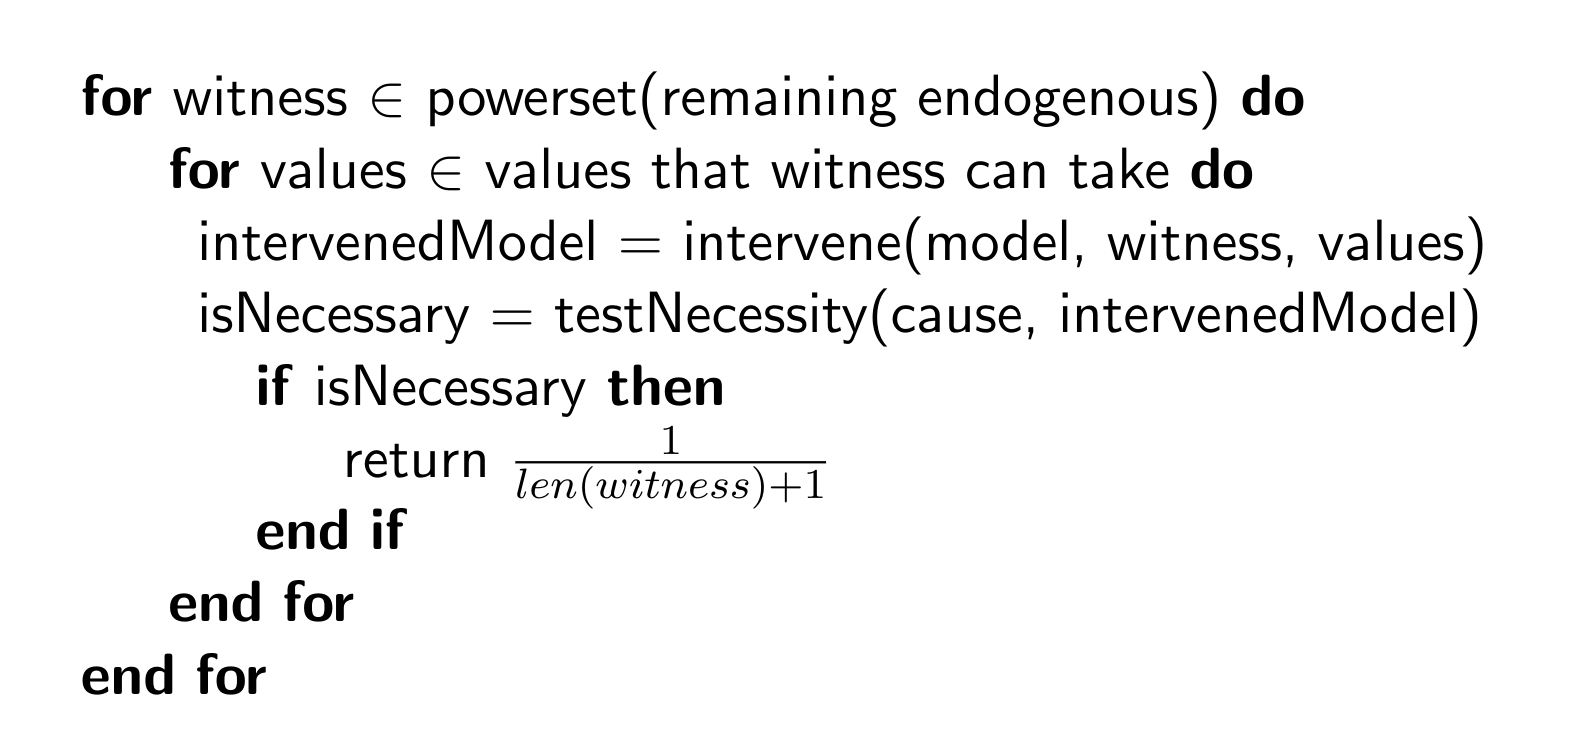

In [13]:
from itertools import chain, combinations
import itertools

def powerset(iterable):
    ''' 
    Finds the powerset of any iterable
    powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)

        Parameters:

            iterable (iterable): Any given iterable

        Returns:

            Powerset (iterable): An iterable that constitutes the powerset of
                                 the input iterable

    '''
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def test_necessity(model, sample, causes, witness_endo_vals, witness, 
                   intervening_endo_set, exo_vars, effect):
    '''
    Tests the but-for causation of a given cause after intervening on a witness
    function

        Parameters:

            model (function): model we sampled from
            sample (dict): specific sample
            causes (list of tuples): a list of tuples where element 0 contains
                                     the name of the endogenous variable and 
                                     element 1 contains its active value
            witness_endo_vals (list): contains values each endogenous variable
                                      in witness can take
            witness (list): list of endogenous variables in the witness 
            intervening_endo_set (list): the set of intervening endogenous 
                                         variables
            exo_vars (list of strings): a list of strings indicating the 
                                        names of exogenous variables 
            effect (tuple): element 0 contains the name of the effect variable
                            and element 1 
        
        Returns: 

            isNecessary (bool): Whether the cause is necessary given the witness
            
    '''

    for intervention_vals in itertools.product(*witness_endo_vals):
        intervention_dict = dict(zip(intervening_endo_set, intervention_vals)) 
        exo_dict = {}
        for exo_var in exo_vars:
            exo_dict[exo_var] = sample[exo_var]

        # Condition on the exogenouos variables
        exogenous_conditioned_model = pyro.condition(model, data=exo_dict)

        # Intervene on the witness endogenous variables
        conditioned_intervened_model = pyro.do(exogenous_conditioned_model, 
                                               data=intervention_dict)

        cause_dict = {}
        for cause in causes:
            cause_dict[cause[0]] = cause[1]
    
        anti_cause_dict = {}
        for cause, value in cause_dict.items():
            anti_cause_dict[cause] = torch.tensor(int(not bool(value)))

        modified_cause = pyro.do(conditioned_intervened_model, 
                                  data=anti_cause_dict)
        if modified_cause()[effect[0]] != effect[1]:
            return True
    
        return False


def degree_of_responsibility(model, sample, causes, endo_set, endo_vals, exo_vars, effect):
    '''
    Computes the degree of blame given a set of exogenous variables, cause and
    other endogenous variables

        Parameters:

            model (function): model we sampled from
            sample (sample): a sample generated by an exogenous set
            causes (list of tuples): The endogenous variable(S) that we are identifying the dob for
            endo_set (list of strings): the other endogenous variables that don't include the cause
            endo_vals (list of tuples): the range of values that each endogenous variable can take (handles discrete only)
            exo_vars (list of strings): the exogenous variables 
            effect (tuple): the endogenous effect and its active value

        Returns: 

            Responsibility (float): The degree of responsibility of the cause
    '''

    allCause = True
    for cause in causes:
        if sample[cause[0]] == cause[1]:
            pass
        else:
            allCause = False

    if not allCause or sample[effect[0]] != effect[1]:
        return 0
  
    # Going by index
    for witness in powerset(list(np.arange(0, len(endo_set)))):
        witness_endo_vals = [endo_vals[i] for i in witness]
        intervening_endo_set = [endo_set[i] for i in witness]
        is_necessary = test_necessity(model, sample, causes, witness_endo_vals, witness, intervening_endo_set, exo_vars, effect)
        if is_necessary:
            return 1 / (len(witness) + 1)
  
    return 0




# Computing Blame

To compute blame, we simply condition on all the samples by which both the cause and the effect happened, then calculate a weighted average of the degree of responsibilities based on the probability distribution of the exogenous variables (the epistemic state). Formally: 

$$dob = \sum_{(M, \vec{u}) \in \mathcal{K}} dr((M, \vec{u}), \vec{X} = \vec{X}, \phi) Pr((M, \vec{u})$$

In [14]:


def compute_blame(causes, effect, model, exo_vars, samples, endo_set, endo_vals):
    '''
    Method computes blame given a set of samples from a model

        Parameters:

            causes (list of tuples): a list of tuples where element 0 contains
                                     the name of the endogenous variable and 
                                     element 1 contains its active value
            effect (tuple): element 0 contains the name of the effect variable
                            and element 1 
            model (function): model we sampled from
            exo_vars (list of strings): a list of strings indicating the 
                                        names of exogenous variables 
            samples (list of dict): the samples sampled from a model
            endo_set (list): list of endogenous variable names other than the 
                             cause
            endo_vals (list): list of values that the endogenous variables can 
                              take 
            intervening_endo_set (list): the set of intervening endogenous 
                                         variables     

        Returns: 

            Blame (float): The degree of blame given the set of samples from
                           a model
    '''
    dob = 0
    counter = 0
  
    for sample in samples:
        allCause = True
        for cause in causes:
            if sample[cause[0]] == cause[1]:
                pass
            else:
                allCause = False
        if allCause and sample[effect[0]] == effect[1]:
            dob += degree_of_responsibility(model=model, 
                                            sample=sample, 
                                            causes=causes, 
                                            effect=effect,
                                            exo_vars=exo_vars,
                                            endo_set=endo_set,
                                            endo_vals=endo_vals)
            counter += 1
  
    return dob / counter

print('blame TV:', 
      compute_blame(causes=[('T', torch.tensor(0))], effect=('P', torch.tensor(0)), 
                    model=model_TV, exo_vars=['U_0', 'U_1'], 
                    samples=samples_TV, endo_set=[], endo_vals=[]))
print('blame beach:', 
      compute_blame(causes=[('B', torch.tensor(1))], effect=('T', torch.tensor(1)), 
                    model=model_beach, exo_vars=['U_0', 'U_1', 'U_2'], 
                    samples=samples_beach, endo_set=[], endo_vals=[]))
print('blame forest fire May:', 
      compute_blame(causes=[('ESM', torch.tensor(1)), ('AS', torch.tensor(0))], 
                    effect=('FF', torch.tensor(1)), model=model_fire, 
                    exo_vars=['U_0', 'U_1', 'U_2'], samples=samples_fire, 
                    endo_set=['ESJ'], endo_vals=[0, 1]))
print('blame forest fire June', 
      compute_blame(causes=[('ESM', torch.tensor(0)), ('ESJ', torch.tensor(1))], 
                    effect=('FF', torch.tensor(2)), model=model_fire, 
                    exo_vars=['U_0', 'U_1', 'U_2'], samples=samples_fire, 
                    endo_set=['AS'], endo_vals=[0, 1]))
print('blame paresis:', 
      compute_blame(causes=[('S', torch.tensor(1))], effect=('P', torch.tensor(1)), 
                    model=model_paresis, exo_vars=['U_0', 'U_1'], 
                    samples=samples_paresis, endo_set=[], endo_vals=[]))
print('blame for arsonist 1 disjunctive:', 
      compute_blame(causes=[('ML1', torch.tensor(1))], 
                    effect=('FB_DISJUNCTIVE', torch.tensor(1)), 
                    model=model_match, exo_vars=['U_0', 'U_1'], 
                    samples=samples_match, endo_set=[], endo_vals=[]))
print('blame for arsonist 2 disjunctive:', 
      compute_blame(causes=[('ML2', torch.tensor(1))], 
                    effect=('FB_DISJUNCTIVE', torch.tensor(1)), 
                    model=model_match, exo_vars=['U_0', 'U_1'], 
                    samples=samples_match, endo_set=[], endo_vals=[]))
print('blame for arsonists conjunctive:', 
      compute_blame(causes=[('ML1', torch.tensor(1)), ('ML2', torch.tensor(1))],
                    effect=('FB_CONJUNCTIVE', torch.tensor(1)), 
                    model=model_match, exo_vars=['U_0', 'U_1'], 
                    samples=samples_match, endo_set=[], endo_vals=[]))




blame TV: 0.9158316633266533
blame beach: 0.46539379474940334
blame forest fire May: 1.0
blame forest fire June 1.0
blame paresis: 1.0
blame for arsonist 1 disjunctive: 0.5085182250396196
blame for arsonist 2 disjunctive: 0.4961413484971568
blame for arsonists conjunctive: 1.0


# Explanations for values of blame

We note that it's somewhat weird to speak about blame in a lot of these examples because blame has an intuitive notion of being a result of a "decision" whereas a lot of these causes are not results of decisions. Thinking about these values of blames as results of decisions may make the quantitative values more intuitive. 

1.   The value of blame assigned to the picture tube be 0.9 as there is still a 10% chance that other exogenous variables causing the picture to fail
2.   The value of blame attached to Victoria going to the beach and getting tanned is 0.5 since there is still a 50% chance that Victoria goes to the tanning salon
3.   The value of blame attached to a forest fire in May given electrical storms in May and no April showers is 1 because those two things always guarantee a forest fire in May
4.   Similar to above, the value of blame attached to a forest fire in June given no electrical storms in May and electrical storms in June is 1 because those two things always guarantee a forest fire in June
5.   The value of blame assigned to Syphillis causing Paresis is 1 because Syphillis is a necessary condition for Paresis and is therefore to blame regardless of context
6.   The disjunctive arsonist case is an interesting one since we only assign blame of 0.5 to either arsonist since they would not be necessary 50% of the time. This symbolizes our models incapability to still quantify notions of "normality" when assigning blame, seeing as dropping matches in a forest is not a "normal" thing to do.
7.   The value of blame assigned to both arsonists dropping matches causing the forest to burn down is 1 as it is necessary for the forest to burn down

